# Text analysis course work

### Apurva dwivedi

In [1]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset
import numpy as np

In [3]:
cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")


val_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="validation",
    cache_dir=cache_dir,
)
print(f"Development/validation dataset with {len(val_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="test",
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset)} instances loaded")
train_texts = train_dataset['text']
train_labels = train_dataset['label']

val_texts = val_dataset['text']
val_labels = val_dataset['label']

test_texts = test_dataset['text']
test_labels = test_dataset['label']

Training dataset with 3257 instances loaded
Development/validation dataset with 374 instances loaded
Test dataset with 1421 instances loaded


In [4]:
import numpy as np
import torch
from datasets import load_dataset
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import word2vec
from gensim.utils import tokenize
import gensim.downloader
import matplotlib.pyplot as plt

In [97]:
import pandas as pd
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})
print("Data types in the training dataset:")
print(train_df.dtypes)

Data types in the training dataset:
text     object
label     int64
dtype: object


In [5]:
nan_counts = train_df.isna().sum()
print("NaN counts in each column:")
print(nan_counts)

NaN counts in each column:
text     0
label    0
dtype: int64


In [6]:
label_counts = train_df['label'].value_counts()

# Print the distinct count of labels
print("Distinct count of labels in train_df:")
print(label_counts)

Distinct count of labels in train_df:
label
0    1400
3     855
1     708
2     294
Name: count, dtype: int64


Lable anotaion

For emotion config:
label: an int
0: anger
1: joy
2: optimism
3: sadness

Distinct count of labels in train_df:


<Axes: xlabel='label', ylabel='count'>

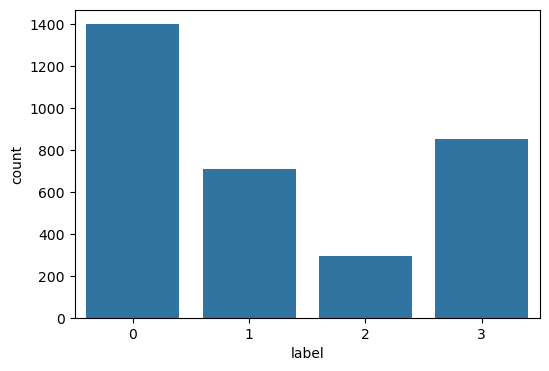

In [73]:
import seaborn as sns
print("Distinct count of labels in train_df:")
plt.figure(figsize=(6, 4))
sns.countplot(x='label',data=train_df)

## DATA Preprocessing 

In [8]:
import neattext.functions as nfx
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

remove 
- stopwords
- userhandles
- punctuations
- special_characters
- remove_numbers

In [98]:
import neattext.functions as nfx
train_df['Clean Text'] = train_df['text'].apply(nfx.remove_stopwords)
train_df['Clean Text'] = train_df['Clean Text'].apply(nfx.remove_userhandles)
train_df['Clean Text'] = train_df['Clean Text'].apply(nfx.remove_punctuations)
train_df['Clean Text'] = train_df['Clean Text'].apply(nfx.remove_special_characters)
train_df['Clean Text'] = train_df['Clean Text'].apply(nfx.remove_numbers)
print(train_df[['text', 'Clean Text']])

                                                   text  \
0     “Worry is a down payment on a problem you may ...   
1     My roommate: it's okay that we can't spell bec...   
2     No but that's so cute. Atsu was probably shy a...   
3     Rooneys fucking untouchable isn't he? Been fuc...   
4     it's pretty depressing when u hit pan on ur fa...   
...                                                 ...   
3252  I get discouraged because I try for 5 fucking ...   
3253  The @user are in contention and hosting @user ...   
3254  @user @user @user @user @user as a fellow UP g...   
3255  You have a #problem? Yes! Can you do #somethin...   
3256  @user @user i will fight this guy! Don't insul...   

                                             Clean Text  
0     Worry payment problem have Joyce Meyer motivat...  
1     roommate okay cant spell autocorrect terrible ...  
2     thats cute Atsu probably shy photos cherry hel...  
3     Rooneys fucking untouchable he fucking dreadfu...  
4

## Tokenisation

In [99]:
tokenized_tweet = train_df['Clean Text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Worry, payment, problem, have, Joyce, Meyer, ...
1    [roommate, okay, cant, spell, autocorrect, ter...
2    [thats, cute, Atsu, probably, shy, photos, che...
3    [Rooneys, fucking, untouchable, he, fucking, d...
4    [pretty, depressing, u, hit, pan, ur, favourit...
Name: Clean Text, dtype: object

In [11]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at e:\ap\envs\text_analytics\lib\site-packages\huggingface_hub-0.21.4-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


## Word Normalisation

In [100]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
tokenized_tweet= tokenized_tweet.apply(lambda sentence: [stemmer.stem (word) for word in sentence])
tokenized_tweet.head()

0    [worri, payment, problem, have, joyc, meyer, m...
1    [roommat, okay, cant, spell, autocorrect, terr...
2    [that, cute, atsu, probabl, shi, photo, cherri...
3    [rooney, fuck, untouch, he, fuck, dread, again...
4    [pretti, depress, u, hit, pan, ur, favourit, h...
Name: Clean Text, dtype: object

## visualize the frequent words

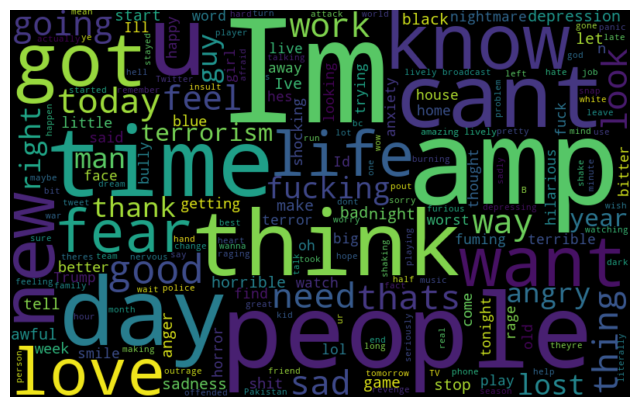

In [14]:
from wordcloud import WordCloud
all_words= ''.join([sentence for sentence in train_df['Clean Text']])
wordcloud= WordCloud(width=800, height=500, random_state=42, max_font_size=188).generate(all_words)
plt.figure(figsize=(8,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sentiment Analysis of the given  Data

Steps 
- Import Libraries
- Define Sentiment Analysis Function
- Apply Sentiment Analysis to Data
- Group Data by Label and Sentiment
- Map Numeric Labels to Emotion Names
- Visualize Sentiment Distribution by Emotion

In [15]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at e:\ap\envs\text_analytics\lib\site-packages\huggingface_hub-0.21.4-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [116]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)  # Fixed '=' was missing.
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        result = "Positive"
    elif sentiment < 0:
        result = "Negative"
    else:
        result = "Neutral"
    return result

In [117]:
get_sentiment("i love u")

'Positive'

In [118]:
train_df["Sentiment"]=train_df['Clean Text'].apply(get_sentiment)

In [119]:
train_df.head()

text  label  \
0  “Worry is a down payment on a problem you may ...      2   
1  My roommate: it's okay that we can't spell bec...      0   
2  No but that's so cute. Atsu was probably shy a...      1   
3  Rooneys fucking untouchable isn't he? Been fuc...      0   
4  it's pretty depressing when u hit pan on ur fa...      3   

                                          Clean Text Sentiment  
0  Worry payment problem have Joyce Meyer motivat...   Neutral  
1  roommate okay cant spell autocorrect terrible ...  Negative  
2  thats cute Atsu probably shy photos cherry hel...   Neutral  
3  Rooneys fucking untouchable he fucking dreadfu...  Negative  
4  pretty depressing u hit pan ur favourite highl...  Negative

In [120]:
train_df.groupby(['label','Sentiment']).size()

label  Sentiment
0      Negative     672
       Neutral      472
       Positive     256
1      Negative      96
       Neutral      206
       Positive     406
2      Negative      58
       Neutral      123
       Positive     113
3      Negative     388
       Neutral      285
       Positive     182
dtype: int64

<Axes: xlabel='label_name,Sentiment'>

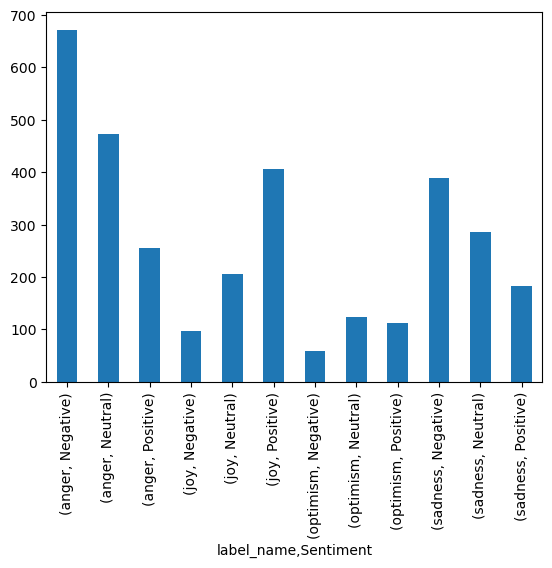

In [121]:
label_mapping = {0: "anger", 1: "joy", 2: "optimism", 3: "sadness"}
train_df['label_name'] = train_df['label'].map(label_mapping)
train_df.groupby(['label_name','Sentiment']).size().plot(kind='bar')

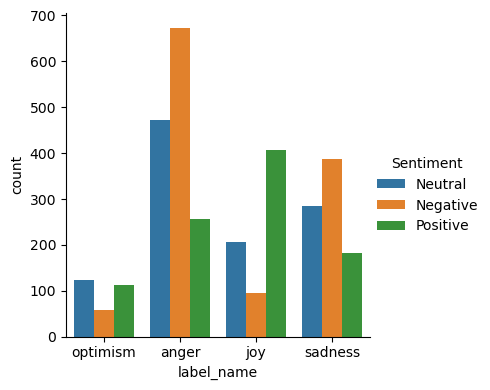

In [123]:
sns.catplot
sns.catplot(x='label_name', hue="Sentiment", data =train_df,kind='count', height=4,aspect=1)

#  Identification of topics that people appear to be optimistic and joyful about

Steps 
- Import Libraries
- Define Function to Extract Keywords
- Define Lists of Emotions
- Filter Data for Optimism
- Extract Keywords for Optimism
- Define Function to Plot Most Common Words
- Plot Most Common Words for Optimism
- Define Function to Plot WordCloud
- Plot WordCloud for Optimism
- Perform Sentiment Analysis for each word in the keywords optimism and joy
- Followed same steps to Plot WordCloud for Joy

## Keyword extraction 

In [124]:
from collections import Counter

def extract_keywords(text, num=50):
    tokens = [token for token in text.split()]
    most_common_tokens = Counter(tokens).most_common(num)
    return dict(most_common_tokens)

In [125]:
emotion_list = train_df['label_name'].unique().tolist()
emotion_list

['optimism', 'anger', 'joy', 'sadness']

In [126]:
optimism_list = train_df[train_df['label_name']=='optimism']['Clean Text'].tolist()
optimism_docx = ' '.join(optimism_list)
keyword_optimism = extract_keywords(optimism_docx)

In [32]:
optimism_docx

'Worry payment problem have Joyce Meyer motivation leadership worry saved ordering risk life panic stayed calm rescued him   Uggh thats horrible bad person stretch imagination hope person realizes that Love happiness sadness feelings dependent person  courage rises attempt intimidate menElizabeth Bennett Pride PrejudicenQuotes Courage FaceYourFears optimism tomorrow foundation today Everybodys worried stopping terrorism Well theres easy way stop participating it  Noam Chomsky     experience plays role that education preparedness fear Anybody know good place book Montreal short supershort notice punkrock postpunk blues afraid space dreams reality dream it make rejoice birth grieve funeral person involved  Mark Twain Need advice rut needmotivation Gloriosa Bazigaga Rwanda work I lost relatives genocide  yrs peacebuilding given optimism power told wife chance  Sydney teams AFL grand final response theres SYDNEY AFL teams serious point living optimist foolish believe best come  Peter Ustin

In [33]:
keyword_optimism

{'fear': 31,
 'worry': 21,
 'optimism': 19,
 'amp': 17,
 'Im': 16,
 'good': 15,
 'life': 14,
 'it': 14,
 'think': 14,
 'start': 13,
 'like': 12,
 'want': 11,
 'know': 10,
 'afraid': 10,
 'quote': 10,
 'let': 10,
 'optimist': 8,
 'better': 8,
 'God': 8,
 'you': 8,
 'anxiety': 8,
 'thats': 7,
 'terrorism': 7,
 'way': 7,
 'work': 7,
 'heart': 7,
 'them': 7,
 'truth': 7,
 'success': 7,
 'faith': 7,
 'wrong': 7,
 'leadership': 6,
 'bad': 6,
 'lost': 6,
 'best': 6,
 'mind': 6,
 'pessimist': 6,
 'takes': 6,
 'got': 6,
 'man': 6,
 'right': 6,
 'u': 6,
 'find': 6,
 'looking': 6,
 'year': 6,
 'person': 5,
 'hope': 5,
 'stop': 5,
 'power': 5,
 'believe': 5}

In [143]:
def plot_most_common_words (mydict):
    df_1= pd.DataFrame(mydict.items(),columns=['token', 'count']) 
    plt.figure(figsize=(15,8)) 
    sns.barplot(x='token', y='count', data=df_1) 
    plt.xticks(rotation=45)
    plt.show()

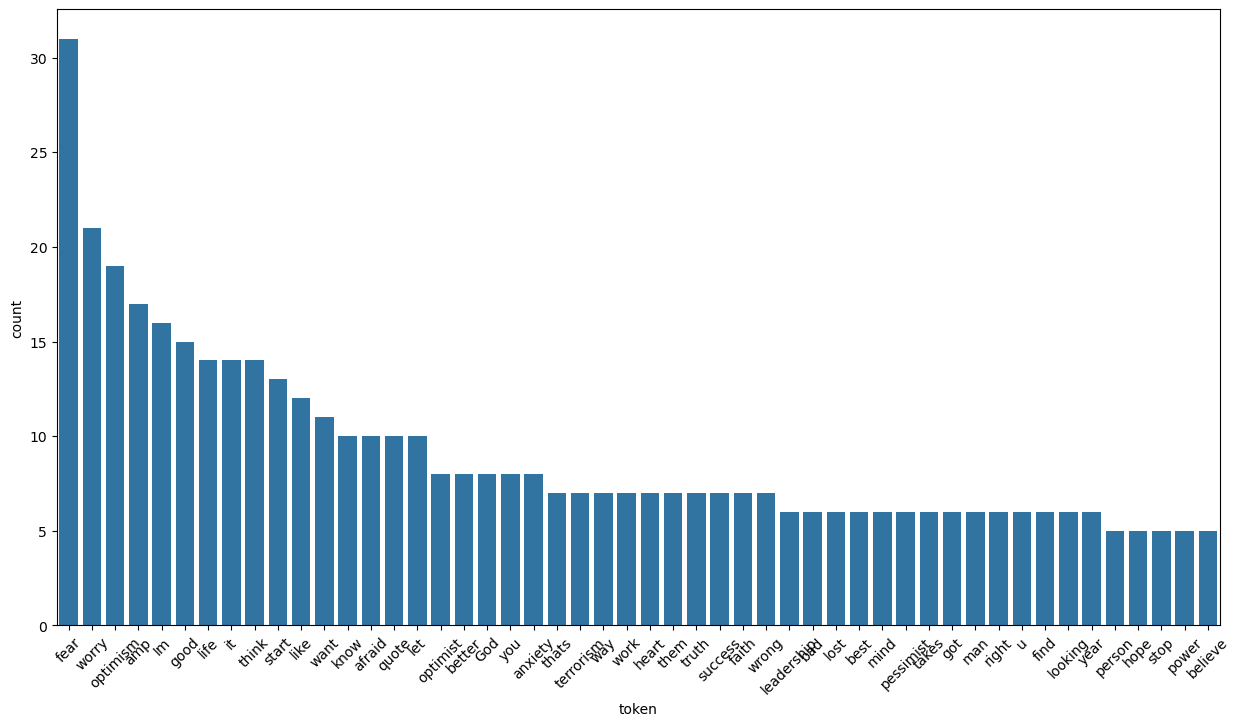

In [144]:
plot_most_common_words (keyword_optimism)

In [153]:
def plot_most_common_words(mydict):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(mydict.items(), columns=['token', 'count'])
    # Sort the DataFrame by count in descending order
    df_sorted = df.sort_values(by='count', ascending=False)
    # Take only the top 5 rows
    df_top5 = df_sorted.head(5)
    
    # Plotting
    plt.figure(figsize=(6, 2))
    sns.barplot(x='token', y='count', data=df_top5)
    plt.xticks(rotation=45)
    plt.xlabel('Token')
    plt.ylabel('Count')
    plt.title('Top 5 Most Common Words')
    plt.show()

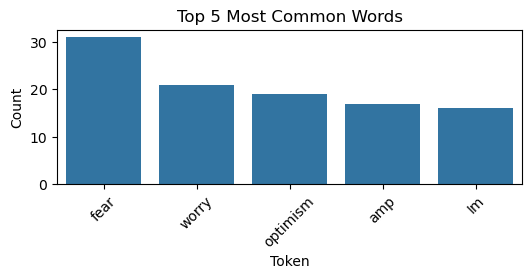

In [154]:
plot_most_common_words(keyword_optimism)

In [147]:
from wordcloud import WordCloud
def plot_wordcloud (docx):
    mywordcloud = WordCloud().generate(docx)
    plt.figure(figsize=(6,4))
    plt.imshow(mywordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

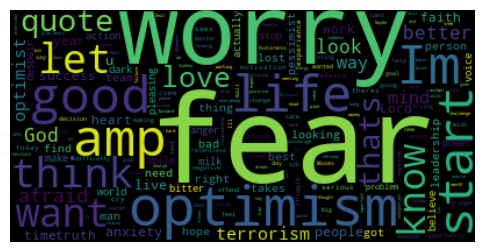

In [148]:
plot_wordcloud(optimism_docx)

In [157]:
sentiment_optimism = {word: get_sentiment(word) for word in keyword_optimism}
print("Sentiment analysis for keywords related to optimism:")
print(sentiment_optimism)

Sentiment analysis for keywords related to optimism:
{'fear': 'Neutral', 'worry': 'Neutral', 'optimism': 'Neutral', 'amp': 'Neutral', 'Im': 'Neutral', 'good': 'Positive', 'life': 'Neutral', 'it': 'Neutral', 'think': 'Neutral', 'start': 'Neutral', 'like': 'Neutral', 'want': 'Neutral', 'know': 'Neutral', 'afraid': 'Negative', 'quote': 'Neutral', 'let': 'Neutral', 'optimist': 'Neutral', 'better': 'Positive', 'God': 'Neutral', 'you': 'Neutral', 'anxiety': 'Neutral', 'thats': 'Neutral', 'terrorism': 'Neutral', 'way': 'Neutral', 'work': 'Neutral', 'heart': 'Neutral', 'them': 'Neutral', 'truth': 'Neutral', 'success': 'Positive', 'faith': 'Neutral', 'wrong': 'Negative', 'leadership': 'Neutral', 'bad': 'Negative', 'lost': 'Neutral', 'best': 'Positive', 'mind': 'Neutral', 'pessimist': 'Neutral', 'takes': 'Neutral', 'got': 'Neutral', 'man': 'Neutral', 'right': 'Positive', 'u': 'Neutral', 'find': 'Neutral', 'looking': 'Neutral', 'year': 'Neutral', 'person': 'Neutral', 'hope': 'Neutral', 'stop': 'N

In [163]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_sentiment_wordclouds(sentiment_dict, title):
    positive_words = {word: sentiment for word, sentiment in sentiment_dict.items() if sentiment == 'Positive'}
    negative_words = {word: sentiment for word, sentiment in sentiment_dict.items() if sentiment == 'Negative'}
    neutral_words = {word: sentiment for word, sentiment in sentiment_dict.items() if sentiment == 'Neutral'}

    positive_text = ' '.join(positive_words.keys())
    negative_text = ' '.join(negative_words.keys())
    neutral_text = ' '.join(neutral_words.keys())

    positive_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(positive_text)
    negative_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(negative_text)
    neutral_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(neutral_text)

    plt.figure(figsize=(8, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title('Positive({})'.format(title))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title('Negative  ({})'.format(title))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(neutral_wordcloud, interpolation='bilinear')
    plt.title('Neutral ({})'.format(title))
    plt.axis('off')

    plt.show()


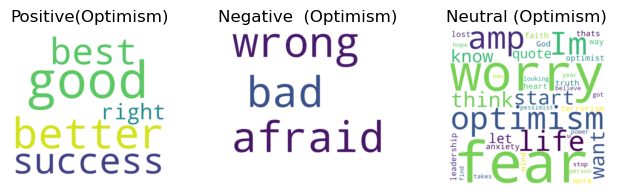

In [164]:
plot_sentiment_wordclouds(sentiment_optimism, 'Optimism')

In [165]:
joy_list = train_df[train_df['label_name']=='joy']['Clean Text'].tolist()
joy_docx = ' '.join(joy_list)
keyword_joy = extract_keywords(joy_docx)

In [42]:
joy_docx

'thats cute Atsu probably shy photos cherry helped uwu Tiller breezy collab album Rapping singing prolly fire angel delight believe Im gonna start singing snap stories tractor Switch little bit started watching glee week addicted  glee GLEEK     ditto amazing atmosphere PhilippPlein cheerleaders stunt LondonEvents cheer Manchester derby home her want playful relationshipnme kicks couch Happy birthday Stephen King man responsible best horror past  years bunch worst good day work shake Jim Lehrers hand Thanks   kicking shy hug   Val got little big hiking boots bakewell little terror GBBO   bts  trilogy MV time fav gloomy beautiful well Thank disney themed episode letting discover amazing   are hilarious Rewatching Raising Hope with hubs time totally forgot hilarious  HereWeGo     wow heard forever Random but great sting xph Happy Birthday LOST  lost dharmainitiative years september oceanic FF nn  nnsoul blues amp rock bandnnmusic heartnnWith soul amp passion nnXx  xX   remember heyday la

In [43]:
keyword_joy

{'amp': 50,
 'Im': 48,
 'lively': 48,
 'love': 38,
 'amazing': 37,
 'hilarious': 37,
 'like': 36,
 'day': 34,
 'Watch': 27,
 'broadcast': 27,
 'musically': 27,
 'blues': 26,
 'happy': 24,
 'lol': 23,
 'new': 22,
 'time': 20,
 'know': 20,
 'got': 19,
 'night': 18,
 'good': 17,
 'glee': 16,
 'horror': 16,
 'smile': 16,
 'great': 15,
 'look': 15,
 'little': 14,
 'birthday': 14,
 'cant': 14,
 'think': 14,
 'im': 14,
 'thats': 13,
 'animated': 13,
 'me': 13,
 'work': 12,
 'people': 12,
 'awe': 12,
 'hilarity': 12,
 'going': 12,
 'sparkling': 12,
 'laughter': 12,
 'breezy': 11,
 'snap': 11,
 'cheer': 11,
 'want': 11,
 'playful': 11,
 'shake': 11,
 'music': 11,
 'play': 11,
 'watch': 11,
 'Ive': 11}

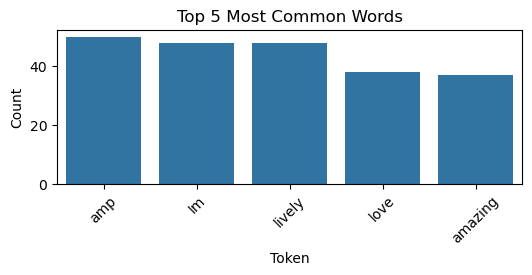

In [166]:
plot_most_common_words(keyword_joy)

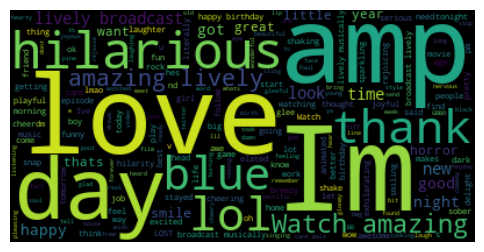

In [167]:
plot_wordcloud(joy_docx)

In [168]:
sentiment_joy = {word: get_sentiment(word) for word in keyword_joy}
print("Sentiment analysis for keywords related to optimism:")
print(sentiment_joy)

Sentiment analysis for keywords related to optimism:
{'amp': 'Neutral', 'Im': 'Neutral', 'lively': 'Positive', 'love': 'Positive', 'amazing': 'Positive', 'hilarious': 'Positive', 'like': 'Neutral', 'day': 'Neutral', 'Watch': 'Neutral', 'broadcast': 'Neutral', 'musically': 'Neutral', 'blues': 'Neutral', 'happy': 'Positive', 'lol': 'Positive', 'new': 'Positive', 'time': 'Neutral', 'know': 'Neutral', 'got': 'Neutral', 'night': 'Neutral', 'good': 'Positive', 'glee': 'Neutral', 'horror': 'Neutral', 'smile': 'Positive', 'great': 'Positive', 'look': 'Neutral', 'little': 'Negative', 'birthday': 'Neutral', 'cant': 'Neutral', 'think': 'Neutral', 'im': 'Neutral', 'thats': 'Neutral', 'animated': 'Neutral', 'me': 'Neutral', 'work': 'Neutral', 'people': 'Neutral', 'awe': 'Neutral', 'hilarity': 'Neutral', 'going': 'Neutral', 'sparkling': 'Neutral', 'laughter': 'Neutral', 'breezy': 'Neutral', 'snap': 'Neutral', 'cheer': 'Neutral', 'want': 'Neutral', 'playful': 'Neutral', 'shake': 'Neutral', 'music': '

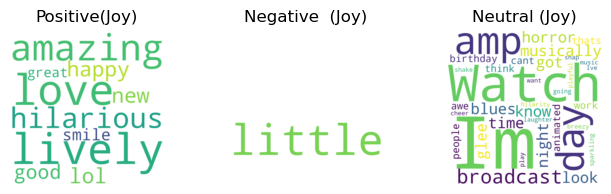

In [169]:
plot_sentiment_wordclouds(sentiment_joy, 'Joy')

# Model implimentation and accuracy

## LogisticRegression Model

In [17]:
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer= CountVectorizer(max_df=0.90, min_df=10, max_features=1000, stop_words="english")
bow=bow_vectorizer.fit_transform(train_df['Clean Text'])

In [19]:
bow[0].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,recall_score,precision_score


x_train, x_test, y_train, y_test = train_test_split(bow, train_df['label'], random_state=42, test_size=0.3)

# Model Training
model = LogisticRegression()
model.fit(x_train, y_train)
pred = model.predict(x_test)



In [21]:
accuracy = accuracy_score(y_test, pred)
print("Accuracy Score:", accuracy)

f1 = f1_score(y_test, pred, average='macro')
print("F1 Score:", f1)

prec = precision_score(y_test, pred, average='macro')
print(f'Precision (macro average) = {prec}')
rec = recall_score(y_test, pred, average='macro')
print(f'Recall (macro average) = {rec}')

print('classification_report')
print(classification_report(y_test, pred))


Accuracy Score: 0.6717791411042945
F1 Score: 0.6016561532021248
Precision (macro average) = 0.6677282325060767
Recall (macro average) = 0.5813295659261866
classification_report
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       409
           1       0.70      0.55      0.62       233
           2       0.66      0.29      0.40       100
           3       0.63      0.62      0.63       236

    accuracy                           0.67       978
   macro avg       0.67      0.58      0.60       978
weighted avg       0.67      0.67      0.66       978



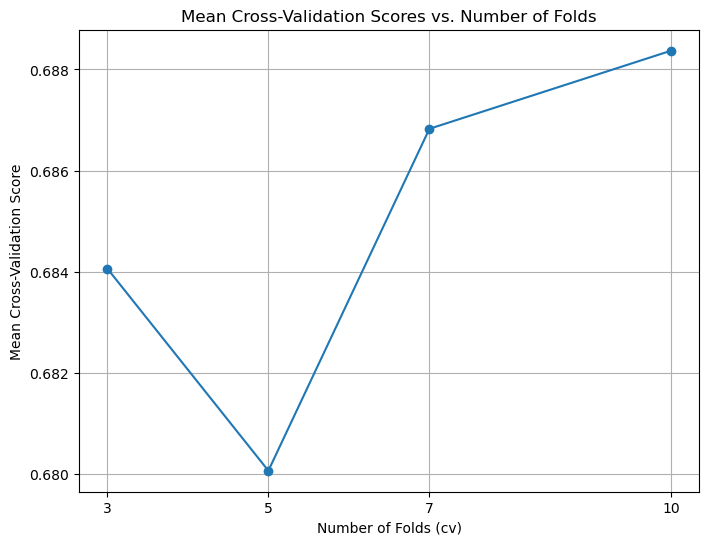

In [22]:
import matplotlib.pyplot as plt

# List to store mean cross-validation scores
mean_scores = []

# Loop over different values of cv
for cv in [3, 5, 7, 10]:
    # Perform cross-validation
    cv_scores = cross_val_score(LogisticRegression(), bow, train_df['label'], cv=cv, scoring='accuracy')
    
    # Append mean cross-validation score to the list
    mean_scores.append(cv_scores.mean())

# Plot the mean cross-validation scores
plt.figure(figsize=(8,6))
plt.plot([3, 5, 7, 10], mean_scores, marker='o')
plt.title('Mean Cross-Validation Scores vs. Number of Folds')
plt.xlabel('Number of Folds (cv)')
plt.ylabel('Mean Cross-Validation Score')
plt.grid(True)
plt.xticks([3, 5, 7, 10])
plt.show()


In [23]:
n_feats_to_show = 10

# Flip the index so that values are keys and keys are values:
keys = bow_vectorizer.vocabulary_.values()
values = bow_vectorizer.vocabulary_.keys()
vocab_inverted = dict(zip(keys, values))

strongest_idxs = np.argsort(model.coef_[0])[-n_feats_to_show:]

for idx in strongest_idxs:
    print(f'{vocab_inverted[idx]} with weight {model.coef_[0][idx]}')

fuck with weight 1.6736249816183302
bully with weight 1.7058189057707434
anger with weight 1.7454931411419945
hate with weight 1.7559697124526035
offended with weight 1.822191167066543
raging with weight 1.8377801514376348
fucking with weight 1.896437598122033
outrage with weight 1.9070553521341578
angry with weight 1.9091528045561386
fuming with weight 2.058978769149518


In [24]:
misclassified_indexes = pred != y_test

# Extract misclassified reviews, predicted labels, and true labels
misclassified_reviews = x_test[misclassified_indexes]
predicted_labels = pred[misclassified_indexes]
true_labels = y_test[misclassified_indexes]

# Print misclassified instances along with their predicted and true labels
for review, predicted_label, true_label in zip(misclassified_reviews, predicted_labels, true_labels):
    print(f'Review: {review}\nPredicted Label: {predicted_label}, True Label: {true_label}\n')

Review:   (0, 261)	1
Predicted Label: 0, True Label: 2

Review:   (0, 379)	1
  (0, 33)	1
  (0, 154)	2
Predicted Label: 1, True Label: 3

Review:   (0, 446)	1
  (0, 313)	1
Predicted Label: 2, True Label: 3

Review:   (0, 217)	1
  (0, 27)	1
  (0, 240)	1
  (0, 242)	1
Predicted Label: 0, True Label: 3

Review:   (0, 235)	1
  (0, 240)	1
  (0, 206)	1
Predicted Label: 0, True Label: 1

Review:   (0, 426)	1
  (0, 217)	1
  (0, 180)	1
  (0, 125)	1
Predicted Label: 1, True Label: 3

Review:   (0, 400)	1
  (0, 410)	1
  (0, 113)	1
Predicted Label: 0, True Label: 3

Review:   (0, 47)	1
Predicted Label: 1, True Label: 3

Review:   (0, 424)	2
  (0, 418)	2
  (0, 1)	1
Predicted Label: 1, True Label: 2

Review: 
Predicted Label: 0, True Label: 1

Review:   (0, 217)	1
  (0, 132)	1
Predicted Label: 3, True Label: 1

Review:   (0, 393)	1
  (0, 211)	1
  (0, 409)	1
  (0, 80)	1
Predicted Label: 0, True Label: 2

Review:   (0, 423)	1
Predicted Label: 0, True Label: 1

Review:   (0, 456)	1
  (0, 220)	1
Predicted

In [72]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object): 
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, tweets):
        return [self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='v'), pos='a') for tok in word_tokenize(tweets)]
    
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer())

vectorizer.fit(train_df['Clean Text'])
X_train = vectorizer.transform(train_df['Clean Text'])
X_test = vectorizer.transform(test_df['text'])

# Print out some of the features in the vocabulary:
print(list(vectorizer.vocabulary_)[:20])

['worry', 'payment', 'problem', 'have', 'joyce', 'meyer', 'motivation', 'leadership', 'roommate', 'okay', 'cant', 'spell', 'autocorrect', 'terrible', 'firstworldprobs', 'thats', 'cute', 'atsu', 'probably', 'shy']


In [73]:
print(f'Vocabulary size: {len(vectorizer.vocabulary_)}')

Vocabulary size: 7169


In [75]:
classifier = LogisticRegression()
classifier.fit(X_train, train_df['label'])
y_test_pred = classifier.predict(X_test)

acc = accuracy_score(test_df['label'], y_test_pred)
print(f'Accuracy = {acc}')

prec = precision_score(test_df['label'], y_test_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_df['label'], y_test_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_df['label'], y_test_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

print(classification_report(test_df['label'], y_test_pred))

Accuracy = 0.6347642505277973
Precision (macro average) = 0.5868205586072134
Recall (macro average) = 0.5642061000004523
F1 score (macro average) = 0.5714156921063668
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       558
           1       0.66      0.56      0.61       358
           2       0.41      0.30      0.35       123
           3       0.57      0.65      0.61       382

    accuracy                           0.63      1421
   macro avg       0.59      0.56      0.57      1421
weighted avg       0.63      0.63      0.63      1421



In [77]:
vectorizer = CountVectorizer(ngram_range=(1,2))

vectorizer.fit(train_df['text'])
X_train = vectorizer.transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])

print(f'Vocabulary size: {len(vectorizer.vocabulary_)}')

# Print out some of the features in the vocabulary:
print(list(vectorizer.vocabulary_)[:20])

Vocabulary size: 39945
['worry', 'is', 'down', 'payment', 'on', 'problem', 'you', 'may', 'never', 'have', 'joyce', 'meyer', 'motivation', 'leadership', 'worry is', 'is down', 'down payment', 'payment on', 'on problem', 'problem you']


In [79]:
classifier = LogisticRegression()
classifier.fit(X_train, train_df['label'])
y_test_pred = classifier.predict(X_test)

acc = accuracy_score(test_df['label'], y_test_pred)
print(f'Accuracy = {acc}')

prec = precision_score(test_df['label'], y_test_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_df['label'], y_test_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_df['label'], y_test_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

print(classification_report(test_df['label'], y_test_pred))

Accuracy = 0.6432090077410274
Precision (macro average) = 0.6154129981416683
Recall (macro average) = 0.5364793369597144
F1 score (macro average) = 0.5497402415133854
              precision    recall  f1-score   support

           0       0.63      0.86      0.72       558
           1       0.70      0.53      0.60       358
           2       0.48      0.17      0.25       123
           3       0.66      0.59      0.63       382

    accuracy                           0.64      1421
   macro avg       0.62      0.54      0.55      1421
weighted avg       0.64      0.64      0.62      1421



# Neural Network Classifier Model

Steps
- tokenising the raw text data 
- create a vocabulary of token types, then convert each token to its index in the vocabulary
- Create a function that maps a sample from tok_train_dataset from a list of tokens 
- plot a histogram to understand the length distribution of the texts in the training set
- choose a fixed sequence length, then pad the documents that are shorter than this maximum
- wrap our dataset in a DataLoader object.
- build a NN with four different layers for sentiment classification
- create a NN with the FFTextClassifier class we wrote
- create a training function to calculate the loss for each input and perform backpropagation to optimise the network.
- download the word embeddings from Gensim
- Evaluate the models
- create and test the LSTM classifier

In [101]:
def tok_text(sample):
    sample["tokens"] = list(tokenize(sample['text']))
    return sample
tok_train_dataset = train_dataset.map(tok_text)
tok_train_dataset

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 3257
})

In [102]:
from gensim.corpora import Dictionary
dictionary = Dictionary(tok_train_dataset["tokens"]) 
print(dictionary)

Dictionary<9310 unique tokens: ['Joyce', 'Meyer', 'Worry', 'a', 'down']...>


In [103]:
dictionary.token2id['a'] + 1 

4

In [104]:
def encode_text(sample):
    input_ids = []
    for token in sample["tokens"]:
        if token in dictionary.token2id: 
            input_ids.append(dictionary.token2id[token] + 1) 
    sample['input_ids'] = input_ids 
    return sample
pre_train_dataset = tok_train_dataset.map(encode_text)
len(pre_train_dataset) 

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

3257

Mean of the document length: 16.516733190052197
Median of the document length: 17.0
Maximum document length: 34


(array([120., 257., 400., 519., 404., 481., 620., 337., 105.,  14.]),
 array([ 1. ,  4.3,  7.6, 10.9, 14.2, 17.5, 20.8, 24.1, 27.4, 30.7, 34. ]),
 <BarContainer object of 10 artists>)

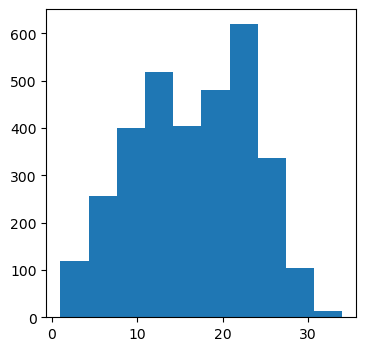

In [105]:
rv_l = [len(doc) for doc in pre_train_dataset['input_ids']]
print('Mean of the document length: {}'.format(np.mean(rv_l)))
print('Median of the document length: {}'.format(np.median(rv_l)))
print('Maximum document length: {}'.format(np.max(rv_l)))
plt.figure(figsize=(4, 4))
plt.hist(rv_l)

In [106]:
sequence_length = 30 
def pad_text(sample):
    if len(sample['input_ids']) >= sequence_length:
        sample['input_ids'] = sample['input_ids'][:sequence_length]
    else:
        sample['input_ids'] = [0]*(sequence_length-len(sample['input_ids'])) + sample['input_ids']
    return sample
pad_train_dataset = pre_train_dataset.map(pad_text)

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

In [107]:
from torch.utils.data import DataLoader, TensorDataset
batch_size = 64
def convert_to_data_loader(dataset, num_classes):
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    tensor_dataset = TensorDataset(input_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)
    return loader
num_classes = len(np.unique(pad_train_dataset["label"]))  
train_loader = convert_to_data_loader(pad_train_dataset, num_classes)

In [108]:
num_classes

4

In [109]:
pre_dev_dataset = val_dataset.map(tok_text).map(encode_text)
pad_dev_dataset = pre_dev_dataset.map(pad_text)
dev_loader = convert_to_data_loader(pad_dev_dataset, num_classes)

pre_test_dataset = test_dataset.map(tok_text).map(encode_text)
pad_test_dataset = pre_test_dataset.map(pad_text)
test_loader = convert_to_data_loader(pad_test_dataset, num_classes)

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Map:   0%|          | 0/374 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

Map:   0%|          | 0/1421 [00:00<?, ? examples/s]

In [110]:
from torch import nn
class FFTextClassifier(nn.Module):
    def __init__(self, vocab_size, sequence_length, embedding_size, hidden_size, num_classes):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_size
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size) 
        self.hidden_layer = nn.Linear(embedding_size*sequence_length, hidden_size) 
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, num_classes) 
        
    def forward (self, input_words):
        embedded_words = self.embedding_layer(input_words) 
        embedded_words = embedded_words.reshape(embedded_words.shape[0], sequence_length*self.embedding_size)
        z = self.hidden_layer(embedded_words)  
        h = self.activation(z) 
        output = self.output_layer(h)
        return output

In [111]:
vocab_size = len(dictionary) + 1 
embedding_size = 25  
hidden_size = 16 
ff_classifier_model = FFTextClassifier(vocab_size, sequence_length, embedding_size, hidden_size, num_classes)

In [112]:
from torch import optim
def train_nn(num_epochs, model, train_dataloader, dev_dataloader):
    learning_rate = 0.0005 
    loss_fn = nn.CrossEntropyLoss()  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
    all_train_losses = []
    all_dev_losses = []
    for e in range(num_epochs):
        total_correct = 0
        total_trained = 0
        train_losses = []
        model.train() 
        for i, (batch_input_ids, batch_labels) in enumerate(train_dataloader):
            optimizer.zero_grad()  
            output = model(batch_input_ids)
            batch_loss = loss_fn(output, batch_labels)
            batch_loss.backward()
            optimizer.step()
            train_losses.append(batch_loss.item())
            predicted_labels = output.argmax(1)
            total_correct += (predicted_labels == batch_labels).sum().item()
            total_trained += batch_labels.size(0)
        train_accuracy = total_correct/total_trained*100
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))
        all_train_losses.append(np.mean(train_losses))
        model.eval()  
        total_correct = 0
        total_trained = 0
        dev_losses = []
        for dev_input_ids, dev_labels in dev_dataloader:
            dev_output = model(dev_input_ids)
            dev_loss = loss_fn(dev_output, dev_labels)
            dev_losses.append(dev_loss.item())
            predicted_labels = dev_output.argmax(1)
            total_correct += (predicted_labels == dev_labels).sum().item()
            total_trained += dev_labels.size(0)
        dev_accuracy = total_correct/total_trained*100
        all_dev_losses.append(np.mean(dev_losses))
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))
    return model, all_train_losses, all_dev_losses

Epoch: 1/50 Training Loss: 1.2839 Training Accuracy: 41.4799%
Epoch: 1/50 Validation Loss: 1.2508 Validation Accuracy: 42.5134%
Epoch: 2/50 Training Loss: 1.2372 Training Accuracy: 43.9668%
Epoch: 2/50 Validation Loss: 1.2356 Validation Accuracy: 41.1765%
Epoch: 3/50 Training Loss: 1.2048 Training Accuracy: 46.3310%
Epoch: 3/50 Validation Loss: 1.2315 Validation Accuracy: 43.5829%
Epoch: 4/50 Training Loss: 1.1700 Training Accuracy: 48.8486%
Epoch: 4/50 Validation Loss: 1.2336 Validation Accuracy: 42.2460%
Epoch: 5/50 Training Loss: 1.1303 Training Accuracy: 50.5680%
Epoch: 5/50 Validation Loss: 1.2285 Validation Accuracy: 44.3850%
Epoch: 6/50 Training Loss: 1.0847 Training Accuracy: 54.5594%
Epoch: 6/50 Validation Loss: 1.2195 Validation Accuracy: 44.9198%
Epoch: 7/50 Training Loss: 1.0339 Training Accuracy: 58.4587%
Epoch: 7/50 Validation Loss: 1.2274 Validation Accuracy: 44.6524%
Epoch: 8/50 Training Loss: 0.9827 Training Accuracy: 61.1913%
Epoch: 8/50 Validation Loss: 1.2633 Valida

Text(0, 0.5, 'loss')

<Figure size 400x200 with 0 Axes>

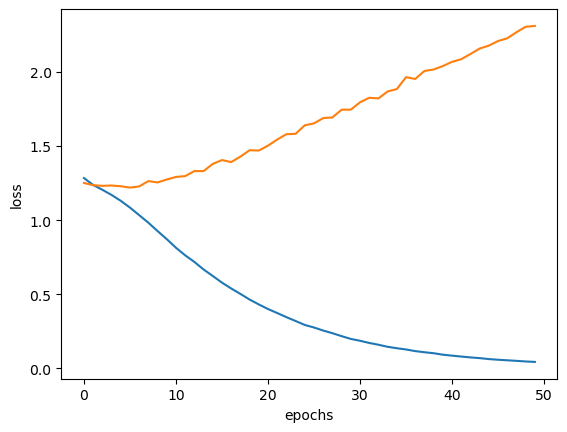

In [113]:
import matplotlib.pyplot as plt
num_epochs = 50
plt.figure(figsize=(4,2))
plt.figure()
trained_model, train_losses, dev_losses = train_nn(num_epochs, ff_classifier_model, train_loader, dev_loader)
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.xlabel('epochs')
plt.ylabel('loss')

In [65]:
def predict_nn(trained_model, test_loader):

    trained_model.eval() 
    correct = 0  
    gold_labs = [] 
    pred_labs = [] 
    for inputs, labels in test_loader:
        test_output = trained_model(inputs) 
        predicted_labels = test_output.argmax(1) 
        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    return gold_labs, pred_labs
gold_labs, pred_labs = predict_nn(trained_model, test_loader)

In [114]:
import gensim.downloader
glove_wv = gensim.downloader.load('glove-twitter-25')

In [67]:
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))
glove_wv.vectors
count = 0
for word in glove_wv.index_to_key:
    if word in dictionary.token2id:
        word_idx = dictionary.token2id[word]
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])
        count +=1     
print(embedding_matrix)
print(count)

C:\Users\Apurva Dwivedi\AppData\Local\Temp\ipykernel_22976\382340001.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4831, -0.4425, -0.5137,  ..., -0.4892, -0.4521, -1.3758],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
6170


In [68]:
class FFTextClassifierWithEmbeddings(FFTextClassifier):
    def __init__(self, hidden_size, sequence_length, num_classes, embedding_matrix):
        super(FFTextClassifier, self).__init__()
        self.embedding_size = embedding_matrix.shape[1] 
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.hidden_layer = nn.Linear(self.embedding_size*sequence_length, hidden_size) 
        self.activation = nn.ReLU() # Hidden layer
        self.output_layer = nn.Linear(hidden_size, num_classes) 

In [69]:
ff_emb_model = FFTextClassifierWithEmbeddings(hidden_size, sequence_length, num_classes, embedding_matrix)
trained_emb_model, _, _ = train_nn(5, ff_emb_model, train_loader, dev_loader)
gold_labs_emb, pred_labs_emb = predict_nn(trained_emb_model, test_loader)

Epoch: 1/5 Training Loss: 1.3093 Training Accuracy: 36.1990%
Epoch: 1/5 Validation Loss: 1.2761 Validation Accuracy: 42.5134%
Epoch: 2/5 Training Loss: 1.2469 Training Accuracy: 43.0765%
Epoch: 2/5 Validation Loss: 1.2657 Validation Accuracy: 40.9091%
Epoch: 3/5 Training Loss: 1.2131 Training Accuracy: 45.0722%
Epoch: 3/5 Validation Loss: 1.2543 Validation Accuracy: 42.7807%
Epoch: 4/5 Training Loss: 1.1668 Training Accuracy: 47.5284%
Epoch: 4/5 Validation Loss: 1.2452 Validation Accuracy: 42.2460%
Epoch: 5/5 Training Loss: 1.1130 Training Accuracy: 52.0725%
Epoch: 5/5 Validation Loss: 1.2417 Validation Accuracy: 41.9786%


In [70]:
from sklearn.metrics import f1_score
print(f'Random embedding intialisation: {f1_score(gold_labs, pred_labs, average="macro")}')
print(f'Frozen pretrained GloVe embeddings: {f1_score(gold_labs_emb, pred_labs_emb, average="macro")}')

Random embedding intialisation: 0.25636470660245625
Frozen pretrained GloVe embeddings: 0.2723868091933895


In [71]:
class LSTMTextClassifierWithEmbeddings(FFTextClassifier):

    def __init__(self, hidden_size, sequence_length, num_classes, embedding_matrix):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.hidden_layer = nn.LSTM(self.embedding_size, hidden_size, bidirectional=True, batch_first=True)
        
        ### COMPLETE THE ARGUMENTS TO SPECIFY THE DIMENSIONS OF THE LAYERS
        self.activation = nn.ReLU() # Hidden layer
        self.output_layer = nn.Linear(2*hidden_size, num_classes) # Full connection layer

    def forward (self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)

        # flatten the sequence of embedding vectors for each document into a single vector.
        # embedded_words = embedded_words.reshape(embedded_words.shape[0], sequence_length*self.embedding_size)  # batch_size, seq_length*embedding_size
        _, (z, _) = self.hidden_layer(embedded_words)   # (2, batch_size, hidden_size)
        z = z.swapaxes(0, 1).flatten(1)
        
        ### ADD THE MISSING LINE HERE
        h = self.activation(z)                  # (batch_size, 2*hidden_size)
        ########
        
        output = self.output_layer(h)                      # (batch_size, num_classes)

        # Notice we haven't applied a softmax activation to the output layer -- it's not required by Pytorch's loss function.

        return output

# WRITE YOUR CODE HERE TO TEST THE LSTM CLASSIFIER
lstm_emb_model = LSTMTextClassifierWithEmbeddings(hidden_size, sequence_length, num_classes, embedding_matrix)
trained_emb_model, _, _ = train_nn(5, lstm_emb_model, train_loader, dev_loader)
gold_labs, pred_labs_lstm = predict_nn(trained_emb_model, test_loader)

Epoch: 1/5 Training Loss: 1.3860 Training Accuracy: 26.4047%
Epoch: 1/5 Validation Loss: 1.3597 Validation Accuracy: 34.2246%
Epoch: 2/5 Training Loss: 1.3116 Training Accuracy: 42.7387%
Epoch: 2/5 Validation Loss: 1.2834 Validation Accuracy: 42.7807%
Epoch: 3/5 Training Loss: 1.2632 Training Accuracy: 42.9843%
Epoch: 3/5 Validation Loss: 1.2542 Validation Accuracy: 42.7807%
Epoch: 4/5 Training Loss: 1.2520 Training Accuracy: 42.9843%
Epoch: 4/5 Validation Loss: 1.2513 Validation Accuracy: 42.7807%
Epoch: 5/5 Training Loss: 1.2398 Training Accuracy: 42.9843%
Epoch: 5/5 Validation Loss: 1.2469 Validation Accuracy: 42.7807%


In [72]:
from sklearn.metrics import f1_score
print(f'LSTM + Pretrained GloVe embeddings: {f1_score(gold_labs, pred_labs_lstm, average="macro")}')

LSTM + Pretrained GloVe embeddings: 0.14098029307731177


# TASK -2
## Bio Creative V

In [3]:
from datasets import load_dataset

In [4]:
ner_dataset = load_dataset(
    "tner/bc5cdr", 
)
print(f'The dataset is a dictionary with {len(ner_dataset)} splits: \n\n{ner_dataset}')

The dataset is a dictionary with 3 splits: 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5228
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5330
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5865
    })
})


In [28]:

train_sentences_ner = [item['tokens'] for item in ner_dataset['train']]
train_labels_ner = [[str(tag) for tag in item['tags']] for item in ner_dataset['train']]

val_sentences_ner = [item['tokens'] for item in ner_dataset['validation']]
val_labels_ner = [[str(tag) for tag in item['tags']] for item in ner_dataset['validation']]

test_sentences_ner = [item['tokens'] for item in ner_dataset['test']]
test_labels_ner = [[str(tag) for tag in item['tags']] for item in ner_dataset['test']]

In [7]:
np.unique(np.concatenate(train_labels_ner))

array(['0', '1', '2', '3', '4'], dtype='<U1')

In [175]:
train_sentences_ner

[['Naloxone',
  'reverses',
  'the',
  'antihypertensive',
  'effect',
  'of',
  'clonidine',
  '.'],
 ['In',
  'unanesthetized',
  ',',
  'spontaneously',
  'hypertensive',
  'rats',
  'the',
  'decrease',
  'in',
  'blood',
  'pressure',
  'and',
  'heart',
  'rate',
  'produced',
  'by',
  'intravenous',
  'clonidine',
  ',',
  '5',
  'to',
  '20',
  'micrograms',
  '/',
  'kg',
  ',',
  'was',
  'inhibited',
  'or',
  'reversed',
  'by',
  'nalozone',
  ',',
  '0',
  '.'],
 ['2', 'to', '2', 'mg', '/', 'kg', '.'],
 ['The',
  'hypotensive',
  'effect',
  'of',
  '100',
  'mg',
  '/',
  'kg',
  'alpha-methyldopa',
  'was',
  'also',
  'partially',
  'reversed',
  'by',
  'naloxone',
  '.'],
 ['Naloxone',
  'alone',
  'did',
  'not',
  'affect',
  'either',
  'blood',
  'pressure',
  'or',
  'heart',
  'rate',
  '.'],
 ['In',
  'brain',
  'membranes',
  'from',
  'spontaneously',
  'hypertensive',
  'rats',
  'clonidine',
  ',',
  '10',
  '(-',
  '8',
  ')',
  'to',
  '10',
  '(-',
  '

In [10]:
tag_mapping = {0: "O",1: "B-Chemical",2: "B-Disease",3: "I-Disease",4: "I-Chemical"}

In [47]:
train_set = [list(zip(s['tokens'], [tag_mapping[tok] for tok in s['tags']])) for s in ner_dataset['train']][:-1]
test_set = [list(zip(s['tokens'], [tag_mapping[tok] for tok in s['tags']])) for s in ner_dataset['test']][:-1]
test_tokens = [s['tokens'] for s in ner_dataset['test']][:-1]
test_tags = [[tag_mapping[tok] for tok in s['tags']] for s in ner_dataset['test']][:-1]

print("Train Set:", train_set[:5])  
print("Test Set:", test_set[:5])   
print("Test Tokens:", test_tokens[:5]) 
print("Test Tags:", test_tags[:5])    

Train Set: [[('Naloxone', 'B-Chemical'), ('reverses', 'O'), ('the', 'O'), ('antihypertensive', 'O'), ('effect', 'O'), ('of', 'O'), ('clonidine', 'B-Chemical'), ('.', 'O')], [('In', 'O'), ('unanesthetized', 'O'), (',', 'O'), ('spontaneously', 'O'), ('hypertensive', 'B-Disease'), ('rats', 'O'), ('the', 'O'), ('decrease', 'O'), ('in', 'O'), ('blood', 'O'), ('pressure', 'O'), ('and', 'O'), ('heart', 'O'), ('rate', 'O'), ('produced', 'O'), ('by', 'O'), ('intravenous', 'O'), ('clonidine', 'B-Chemical'), (',', 'O'), ('5', 'O'), ('to', 'O'), ('20', 'O'), ('micrograms', 'O'), ('/', 'O'), ('kg', 'O'), (',', 'O'), ('was', 'O'), ('inhibited', 'O'), ('or', 'O'), ('reversed', 'O'), ('by', 'O'), ('nalozone', 'B-Chemical'), (',', 'O'), ('0', 'O'), ('.', 'O')], [('2', 'O'), ('to', 'O'), ('2', 'O'), ('mg', 'O'), ('/', 'O'), ('kg', 'O'), ('.', 'O')], [('The', 'O'), ('hypotensive', 'B-Disease'), ('effect', 'O'), ('of', 'O'), ('100', 'O'), ('mg', 'O'), ('/', 'O'), ('kg', 'O'), ('alpha-methyldopa', 'B-Chemi

In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define function for text preprocessing
def preprocess_text(text):
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)
    
    # Remove non-word tokens and filter tokens by length
    tokens = [token for token in tokens if re.match(r'^[a-zA-Z]+$', token) and len(token) >= 3 and len(token) <= 15]
    
    # Convert tokens to lower case
    tokens = [token.lower() for token in tokens]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

# Preprocess the text data
train_set = [[(preprocess_text(token), tag) for token, tag in entry] for entry in train_set]
test_set = [[(preprocess_text(token), tag) for token, tag in entry] for entry in test_set]


# Example usage
print("Preprocessed Train Set:", preprocessed_train_set[:2])
print("Preprocessed Test Set:", preprocessed_test_set[:2])


[nltk_data] Downloading package punkt to C:\Users\Apurva
[nltk_data]     Dwivedi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Apurva
[nltk_data]     Dwivedi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Apurva
[nltk_data]     Dwivedi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed Train Set: [[(['naloxone'], 'B-Chemical'), (['revers'], 'O'), ([], 'O'), ([], 'O'), (['effect'], 'O'), ([], 'O'), (['clonidine'], 'B-Chemical'), ([], 'O')], [([], 'O'), (['unanesthetized'], 'O'), ([], 'O'), (['spontaneously'], 'O'), (['hypertensive'], 'B-Disease'), (['rat'], 'O'), ([], 'O'), (['decrease'], 'O'), ([], 'O'), (['blood'], 'O'), (['pressure'], 'O'), ([], 'O'), (['heart'], 'O'), (['rate'], 'O'), (['produced'], 'O'), ([], 'O'), (['intravenous'], 'O'), (['clonidine'], 'B-Chemical'), ([], 'O'), ([], 'O'), ([], 'O'), ([], 'O'), (['microgram'], 'O'), ([], 'O'), ([], 'O'), ([], 'O'), ([], 'O'), (['inhibited'], 'O'), ([], 'O'), (['reversed'], 'O'), ([], 'O'), (['nalozone'], 'B-Chemical'), ([], 'O'), ([], 'O'), ([], 'O')]]
Preprocessed Test Set: [[(['famotidine'], 'B-Chemical'), ([], 'O'), (['associated'], 'O'), (['delirium'], 'B-Disease'), ([], 'O')], [([], 'O'), (['series'], 'O'), ([], 'O'), (['six'], 'O'), (['case'], 'O'), ([], 'O')]]


In [12]:
train_data = ner_dataset['train']
print(train_data[:5])  # View the first 5 examples in the train split


{'tokens': [['Naloxone', 'reverses', 'the', 'antihypertensive', 'effect', 'of', 'clonidine', '.'], ['In', 'unanesthetized', ',', 'spontaneously', 'hypertensive', 'rats', 'the', 'decrease', 'in', 'blood', 'pressure', 'and', 'heart', 'rate', 'produced', 'by', 'intravenous', 'clonidine', ',', '5', 'to', '20', 'micrograms', '/', 'kg', ',', 'was', 'inhibited', 'or', 'reversed', 'by', 'nalozone', ',', '0', '.'], ['2', 'to', '2', 'mg', '/', 'kg', '.'], ['The', 'hypotensive', 'effect', 'of', '100', 'mg', '/', 'kg', 'alpha-methyldopa', 'was', 'also', 'partially', 'reversed', 'by', 'naloxone', '.'], ['Naloxone', 'alone', 'did', 'not', 'affect', 'either', 'blood', 'pressure', 'or', 'heart', 'rate', '.']], 'tags': [[1, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [184]:
# Collect all unique tags
unique_tags = set()

# Collect all tags from train_set
all_tags = []
for entry in train_set:
    all_tags.extend([tag for _, tag in entry])
    unique_tags.update(all_tags)

# Count the distinct tags
distinct_tag_count = len(unique_tags)

# Print the result
print("Distinct tag count:", distinct_tag_count)

# Print the distinct tags
print("Distinct tags:", unique_tags)

from collections import Counter

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

# Print the count of each unique tag
for tag, count in tag_counts.items():
    print(f"{tag}: {count}")


Distinct tag count: 5
Distinct tags: {'I-Disease', 'I-Chemical', 'B-Disease', 'O', 'B-Chemical'}
B-Chemical: 5201
O: 96789
B-Disease: 4182
I-Disease: 2570
I-Chemical: 571


In [185]:
# Select a B-Disease entity
b_disease_entities = []

# Iterate through the test set to find B-Disease entities
for entry in test_set:
    for token, tag in entry:
        if tag == 'B-Disease':
            b_disease_entities.append(token)

# Print the first few B-Disease entities
print("First few B-Disease entities:", b_disease_entities[:5])


First few B-Disease entities: ['delirium', 'ulcers', 'delirium', 'delirium', 'hypotension']


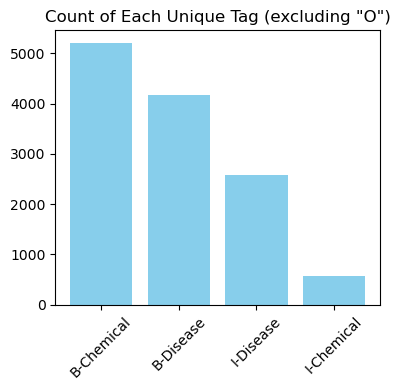

In [189]:
import matplotlib.pyplot as plt

# Remove the 'O' tag from the tag_counts dictionary
tag_counts_without_O = {tag: count for tag, count in tag_counts.items() if tag != 'O'}

# Extract the tags and their counts
tags_without_O = list(tag_counts_without_O.keys())
counts_without_O = list(tag_counts_without_O.values())

# Plot the count of each unique tag (excluding 'O')
plt.figure(figsize=(4,4))
plt.bar(tags_without_O, counts_without_O, color='skyblue')
plt.title('Count of Each Unique Tag (excluding "O")')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


In [191]:
import nltk

# Train a CRF NER tagger
def train_CRF_NER_tagger(train_set):
    # Initialize CRFTagger
    tagger = nltk.tag.CRFTagger()
    # Train the CRF tagger
    tagger.train(train_set, 'model.crf.tagger')
    # Return the trained model
    return tagger

# Call the function to train the CRF NER tagger
trained_tagger = train_CRF_NER_tagger(train_set)


In [206]:
predicted_tags = trained_tagger.tag_sents(test_tokens)
predicted_tags

[[('Famotidine', 'B-Chemical'),
  ('-', 'O'),
  ('associated', 'O'),
  ('delirium', 'B-Chemical'),
  ('.', 'O')],
 [('A', 'O'),
  ('series', 'O'),
  ('of', 'O'),
  ('six', 'O'),
  ('cases', 'O'),
  ('.', 'O')],
 [('Famotidine', 'B-Chemical'),
  ('is', 'O'),
  ('a', 'O'),
  ('histamine', 'B-Chemical'),
  ('H2', 'I-Chemical'),
  ('-', 'O'),
  ('receptor', 'O'),
  ('antagonist', 'O'),
  ('used', 'O'),
  ('in', 'O'),
  ('inpatient', 'O'),
  ('settings', 'O'),
  ('for', 'O'),
  ('prevention', 'O'),
  ('of', 'O'),
  ('stress', 'O'),
  ('ulcers', 'O'),
  ('and', 'O'),
  ('is', 'O'),
  ('showing', 'O'),
  ('increasing', 'O'),
  ('popularity', 'O'),
  ('because', 'O'),
  ('of', 'O'),
  ('its', 'O'),
  ('low', 'O'),
  ('cost', 'O'),
  ('.', 'O')],
 [('Although', 'O'),
  ('all', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('currently', 'O'),
  ('available', 'O'),
  ('H2', 'O'),
  ('-', 'O'),
  ('receptor', 'O'),
  ('antagonists', 'O'),
  ('have', 'O'),
  ('shown', 'O'),
  ('the', 'O'),
  ('propensity'

In [208]:
misclassified_indexes = [i for i in range(len(test_tags)) if predicted_tags[i] != test_tags[i]]

# Extract misclassified reviews, predicted labels, and true labels
misclassified_reviews = [test_tokens[i] for i in misclassified_indexes]
predicted_labels = [predicted_tags[i] for i in misclassified_indexes]
true_labels = [test_tags[i] for i in misclassified_indexes]

# Print misclassified instances along with their predicted and true labels
for review, predicted_label, true_label in zip(misclassified_reviews, predicted_labels, true_labels):
    print(f'Review: {review}\nPredicted Label: {predicted_label}, True Label: {true_label}\n')


Review: ['Famotidine', '-', 'associated', 'delirium', '.']
Predicted Label: [('Famotidine', 'B-Chemical'), ('-', 'O'), ('associated', 'O'), ('delirium', 'B-Chemical'), ('.', 'O')], True Label: ['B-Chemical', 'O', 'O', 'B-Disease', 'O']

Review: ['A', 'series', 'of', 'six', 'cases', '.']
Predicted Label: [('A', 'O'), ('series', 'O'), ('of', 'O'), ('six', 'O'), ('cases', 'O'), ('.', 'O')], True Label: ['O', 'O', 'O', 'O', 'O', 'O']

Review: ['Famotidine', 'is', 'a', 'histamine', 'H2', '-', 'receptor', 'antagonist', 'used', 'in', 'inpatient', 'settings', 'for', 'prevention', 'of', 'stress', 'ulcers', 'and', 'is', 'showing', 'increasing', 'popularity', 'because', 'of', 'its', 'low', 'cost', '.']
Predicted Label: [('Famotidine', 'B-Chemical'), ('is', 'O'), ('a', 'O'), ('histamine', 'B-Chemical'), ('H2', 'I-Chemical'), ('-', 'O'), ('receptor', 'O'), ('antagonist', 'O'), ('used', 'O'), ('in', 'O'), ('inpatient', 'O'), ('settings', 'O'), ('for', 'O'), ('prevention', 'O'), ('of', 'O'), ('stress

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [195]:
def extract_spans(tagged_sents):
    spans = {}
        
    for sidx, sent in enumerate(tagged_sents):
        start = -1
        entity_type = None
        for i, (tok, lab) in enumerate(sent):
            if 'B-' in lab:
                start = i
                end = i + 1
                entity_type = lab[2:]
            elif 'I-' in lab:
                end = i + 1
            elif lab == 'O' and start >= 0:
                
                if entity_type not in spans:
                    spans[entity_type] = []
                
                spans[entity_type].append((start, end, sidx))
                start = -1      
         
        if start >= 0:    
            if entity_type not in spans:
                spans[entity_type] = []
                
            spans[entity_type].append((start, end, sidx))
                
    return spans

In [196]:
def cal_span_level_f1(test_sents, test_sents_with_pred):
    # get a list of spans from the test set labels
    gold_spans = extract_spans(test_sents)

    # get a list of spans predicted by our tagger
    pred_spans = extract_spans(test_sents_with_pred)
    
    # compute the metrics for each class:
    f1_per_class = []
    
    ne_types = gold_spans.keys()  # get the list of named entity types (not the tags)
    
    for ne_type in ne_types:
        # compute the confusion matrix
        true_pos = 0
        false_pos = 0
        
        for span in pred_spans[ne_type]:
            if span in gold_spans[ne_type]:
                true_pos += 1
            else:
                false_pos += 1
                
        false_neg = 0
        for span in gold_spans[ne_type]:
            if span not in pred_spans[ne_type]:
                false_neg += 1
                
        if true_pos + false_pos == 0:
            precision = 0
        else:
            precision = true_pos / float(true_pos + false_pos)
            
        if true_pos + false_neg == 0:
            recall = 0
        else:
            recall = true_pos / float(true_pos + false_neg)
        
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * precision * recall / (precision + recall)
            
        f1_per_class.append(f1)
        print(f'F1 score for class {ne_type} = {f1}')
        
    print(f'Macro-average f1 score = {np.mean(f1_per_class)}')

cal_span_level_f1(test_set, predicted_tags)

F1 score for class Chemical = 0.815220700152207
F1 score for class Disease = 0.6491898300619154
Macro-average f1 score = 0.7322052651070612


In [197]:
import re, unicodedata

class CustomCRFTagger(nltk.tag.CRFTagger):
    _current_tokens = None
    
    def _get_features(self, tokens, idx):
            """
            Extract basic features about this word including
                - Current word
                - is it capitalized?
                - Does it have punctuation?
                - Does it have a number?
                - Suffixes up to length 3

            Note that : we might include feature over previous word, next word etc.

            :return: a list which contains the features
            :rtype: list(str)
            """
            token = tokens[idx]

            feature_list = []

            if not token:
                return feature_list

            # Capitalization
            if token[0].isupper():
                feature_list.append("CAPITALIZATION")

            # Number
            if re.search(self._pattern, token) is not None:
                feature_list.append("HAS_NUM")

            # Punctuation
            punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
            if all(unicodedata.category(x) in punc_cat for x in token):
                feature_list.append("PUNCTUATION")

            # Suffix up to length 3
            if len(token) > 1:
                feature_list.append("SUF_" + token[-1:])
            if len(token) > 2:
                feature_list.append("SUF_" + token[-2:])
            if len(token) > 3:
                feature_list.append("SUF_" + token[-3:])

                
            # Current word
            feature_list.append("WORD_" + token)
            
            ### WRITE YOUR OWN CODE HERE ###
            if idx > 0:
                feature_list.append("PREVWORD_" + tokens[idx-1])
            if idx < len(tokens)-1:
                feature_list.append("NEXTWORD_" + tokens[idx+1])
                
            ####

            return feature_list
                

In [198]:
# Train a CRF NER tagger
def train_CustomCRF_NER_tagger(train_set):
    ### WRITE YOUR OWN CODE HERE
    tagger = CustomCRFTagger()
    tagger.train(train_set, 'model.crf.tagger')
    return tagger  # return the trained model

tagger = train_CustomCRF_NER_tagger(train_set)

In [199]:
predicted_tags = tagger.tag_sents(test_tokens)
cal_span_level_f1(test_set, predicted_tags)

F1 score for class Chemical = 0.8206273474774134
F1 score for class Disease = 0.6919700490575782
Macro-average f1 score = 0.7562986982674957


# Smilarity

In [ ]:
train_set = [list(zip(s['tokens'], [tag_mapping[tok] for tok in s['tags']])) for s in ner_dataset['train']][:-1]
test_set = [list(zip(s['tokens'], [tag_mapping[tok] for tok in s['tags']])) for s in ner_dataset['test']][:-1]

test_tokens = [s['tokens'] for s in ner_dataset['test']][:-1]
test_tags = [[tag_mapping[tok] for tok in s['tags']] for s in ner_dataset['test']][:-1]

print("Train Set:", train_set[:5])  
print("Test Set:", test_set[:5])   
print("Test Tokens:", test_tokens[:5]) 
print("Test Tags:", test_tags[:5])    

In [39]:
train_tokens = [s['tokens'] for s in ner_dataset['train']][:-1]
train_tags = [[tag_mapping[tok] for tok in s['tags']] for s in ner_dataset['train']][:-1]

In [38]:
# Preprocess the text data
train_set = [[(preprocess_text(token), tag) for token, tag in entry] for entry in train_set]
test_set = [[(preprocess_text(token), tag) for token, tag in entry] for entry in test_set]


In [41]:
preprocessed_train_tokens = []
for tokens in test_tokens:
    preprocessed_tokens = [preprocess_text(token) for token in tokens]
    preprocessed_test_tokens.append(preprocessed_tokens)

In [33]:
preprocessed_test_tokens = []
for tokens in test_tokens:
    preprocessed_tokens = [preprocess_text(token) for token in tokens]
    preprocessed_test_tokens.append(preprocessed_tokens)

In [35]:
print("Preprocessed Test tokens:", preprocessed_test_tokens[:2])

Preprocessed Test tokens: [[['naloxone'], ['revers'], [], [], ['effect'], [], ['clonidine'], []], [[], ['unanesthetized'], [], ['spontaneously'], ['hypertensive'], ['rat'], [], ['decrease'], [], ['blood'], ['pressure'], [], ['heart'], ['rate'], ['produced'], [], ['intravenous'], ['clonidine'], [], [], [], [], ['microgram'], [], [], [], [], ['inhibited'], [], ['reversed'], [], ['nalozone'], [], [], []]]


In [13]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import numpy as np

# Filter tokens based on tags ('B-Disease') to select the query entity
query_entity_index = None
for i, tags in enumerate(train_data['tags']):
    if 2 in tags:  #  tag '2' corresponds to 'B-Disease'
        query_entity_index = i
        break

# Retrieve the tokens and tags for the query entity using the identified index
query_entity_tokens = train_data['tokens'][query_entity_index]
query_entity_tags = train_data['tags'][query_entity_index]

# Assuming train_data contains both 'tokens' and 'tags' keys

# Create a dictionary from the train tokens
dictionary = Dictionary(train_data['tokens'])

# Convert the train tokens into bag-of-words representation
train_bow = [dictionary.doc2bow(tokens) for tokens in train_data['tokens']]

# Initialize TF-IDF model with the dictionary and bag-of-words representations
tfidf_model = TfidfModel(train_bow)

# Compute TF-IDF vector for the query entity
query_tfidf = tfidf_model[dictionary.doc2bow(query_entity_tokens)]

# Convert TF-IDF vector to dense vector
query_tfidf_vec = np.zeros(len(dictionary))
for idx, count in query_tfidf:
    query_tfidf_vec[idx] = count

# Select comparison disease entities from the test set
comparison_entities = train_data['tokens'][1:6]  # Choose the next five disease entities from the train set for comparison

# Compute cosine similarity between the query entity and comparison entities
similarities = []
for comp_entity in comparison_entities:
    comp_tfidf = tfidf_model[dictionary.doc2bow(comp_entity)]
    comp_tfidf_vec = np.zeros(len(dictionary))
    for idx, count in comp_tfidf:
        comp_tfidf_vec[idx] = count
    similarity = np.dot(query_tfidf_vec, comp_tfidf_vec) / (np.linalg.norm(query_tfidf_vec) * np.linalg.norm(comp_tfidf_vec))
    similarities.append(similarity)

# Print the computed similarities
print("Similarities with the query disease entity:")
for idx, similarity in enumerate(similarities):
    print(f" {idx + 1}: {similarity}")


Similarities with the query disease entity:
 1: 1.0
 2: 0.10426925998806842
 3: 0.15122710545662443
 4: 0.19174637697941868
 5: 0.20413060914591294


In [17]:
# Print the computed similarities with entity names
print("Similarities with the query disease entity:")
for idx, (entity, similarity) in enumerate(zip(comparison_entities, similarities), start=1):
    print(f" {idx}: {entity} - Similarity: {similarity}")


Similarities with the query disease entity:
 1: ['In', 'unanesthetized', ',', 'spontaneously', 'hypertensive', 'rats', 'the', 'decrease', 'in', 'blood', 'pressure', 'and', 'heart', 'rate', 'produced', 'by', 'intravenous', 'clonidine', ',', '5', 'to', '20', 'micrograms', '/', 'kg', ',', 'was', 'inhibited', 'or', 'reversed', 'by', 'nalozone', ',', '0', '.'] - Similarity: 1.0
 2: ['2', 'to', '2', 'mg', '/', 'kg', '.'] - Similarity: 0.10426925998806841
 3: ['The', 'hypotensive', 'effect', 'of', '100', 'mg', '/', 'kg', 'alpha-methyldopa', 'was', 'also', 'partially', 'reversed', 'by', 'naloxone', '.'] - Similarity: 0.15122710545662443
 4: ['Naloxone', 'alone', 'did', 'not', 'affect', 'either', 'blood', 'pressure', 'or', 'heart', 'rate', '.'] - Similarity: 0.19174637697941868
 5: ['In', 'brain', 'membranes', 'from', 'spontaneously', 'hypertensive', 'rats', 'clonidine', ',', '10', '(-', '8', ')', 'to', '10', '(-', '5', ')', 'M', ',', 'did', 'not', 'influence', 'stereoselective', 'binding', 'of